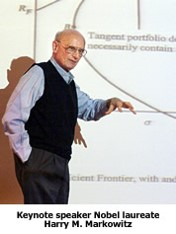

# Frontier Analysis

### The stocks selected for this example are Apple, Amazon, Google, Catpillar, MacDonald, Bank of America, Tesla, and Pfizer.

Next code block will get daily adjusted closing price of each stock



## We download the data from quandl
We use 'Adj Close' for the stoch price

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install quandl
import quandl
import scipy.optimize as sco

np.random.seed(42)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

quandl.ApiConfig.api_key = 'PNzc8CxVBCyfmzjfFqaz'
stocks = ['AAPL','AMZN','GOOGL','BAC', 'MCD', 'CAT', 'TSLA','PFE']
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2016-1-1', 'lte': '2022-12-31' }, paginate=True)
data.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,date,ticker,adj_close
None,,,
0,2018-03-27,TSLA,279.18
1,2018-03-26,TSLA,304.18
2,2018-03-23,TSLA,301.54
3,2018-03-22,TSLA,309.10
4,2018-03-21,TSLA,316.53


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4486 entries, 0 to 4485
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       4486 non-null   datetime64[ns]
 1   ticker     4486 non-null   object        
 2   adj_close  4486 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 105.3+ KB


In [ ]:
data.ticker.unique()

array(['TSLA', 'PFE', 'MCD', 'GOOGL', 'CAT', 'BAC', 'AMZN', 'AAPL'],
      dtype=object)

### Dataset we use

In [ ]:
df = data.set_index('date')
table = df.pivot(columns='ticker')
table.columns = table.columns.droplevel(0)
table.tail(3)

ticker,AAPL,AMZN,BAC,CAT,GOOGL,MCD,PFE,TSLA
date,,,,,,,,
2018-03-23,164.94,1495.56,29.17,144.29,1026.55,154.98,34.49,301.54
2018-03-26,172.77,1555.86,30.44,149.19,1054.09,158.01,35.04,304.18
2018-03-27,168.34,1497.05,29.52,146.99,1006.94,157.48,35.01,279.18


# Visualize the stock price

Text(0, 0.5, 'price in $')

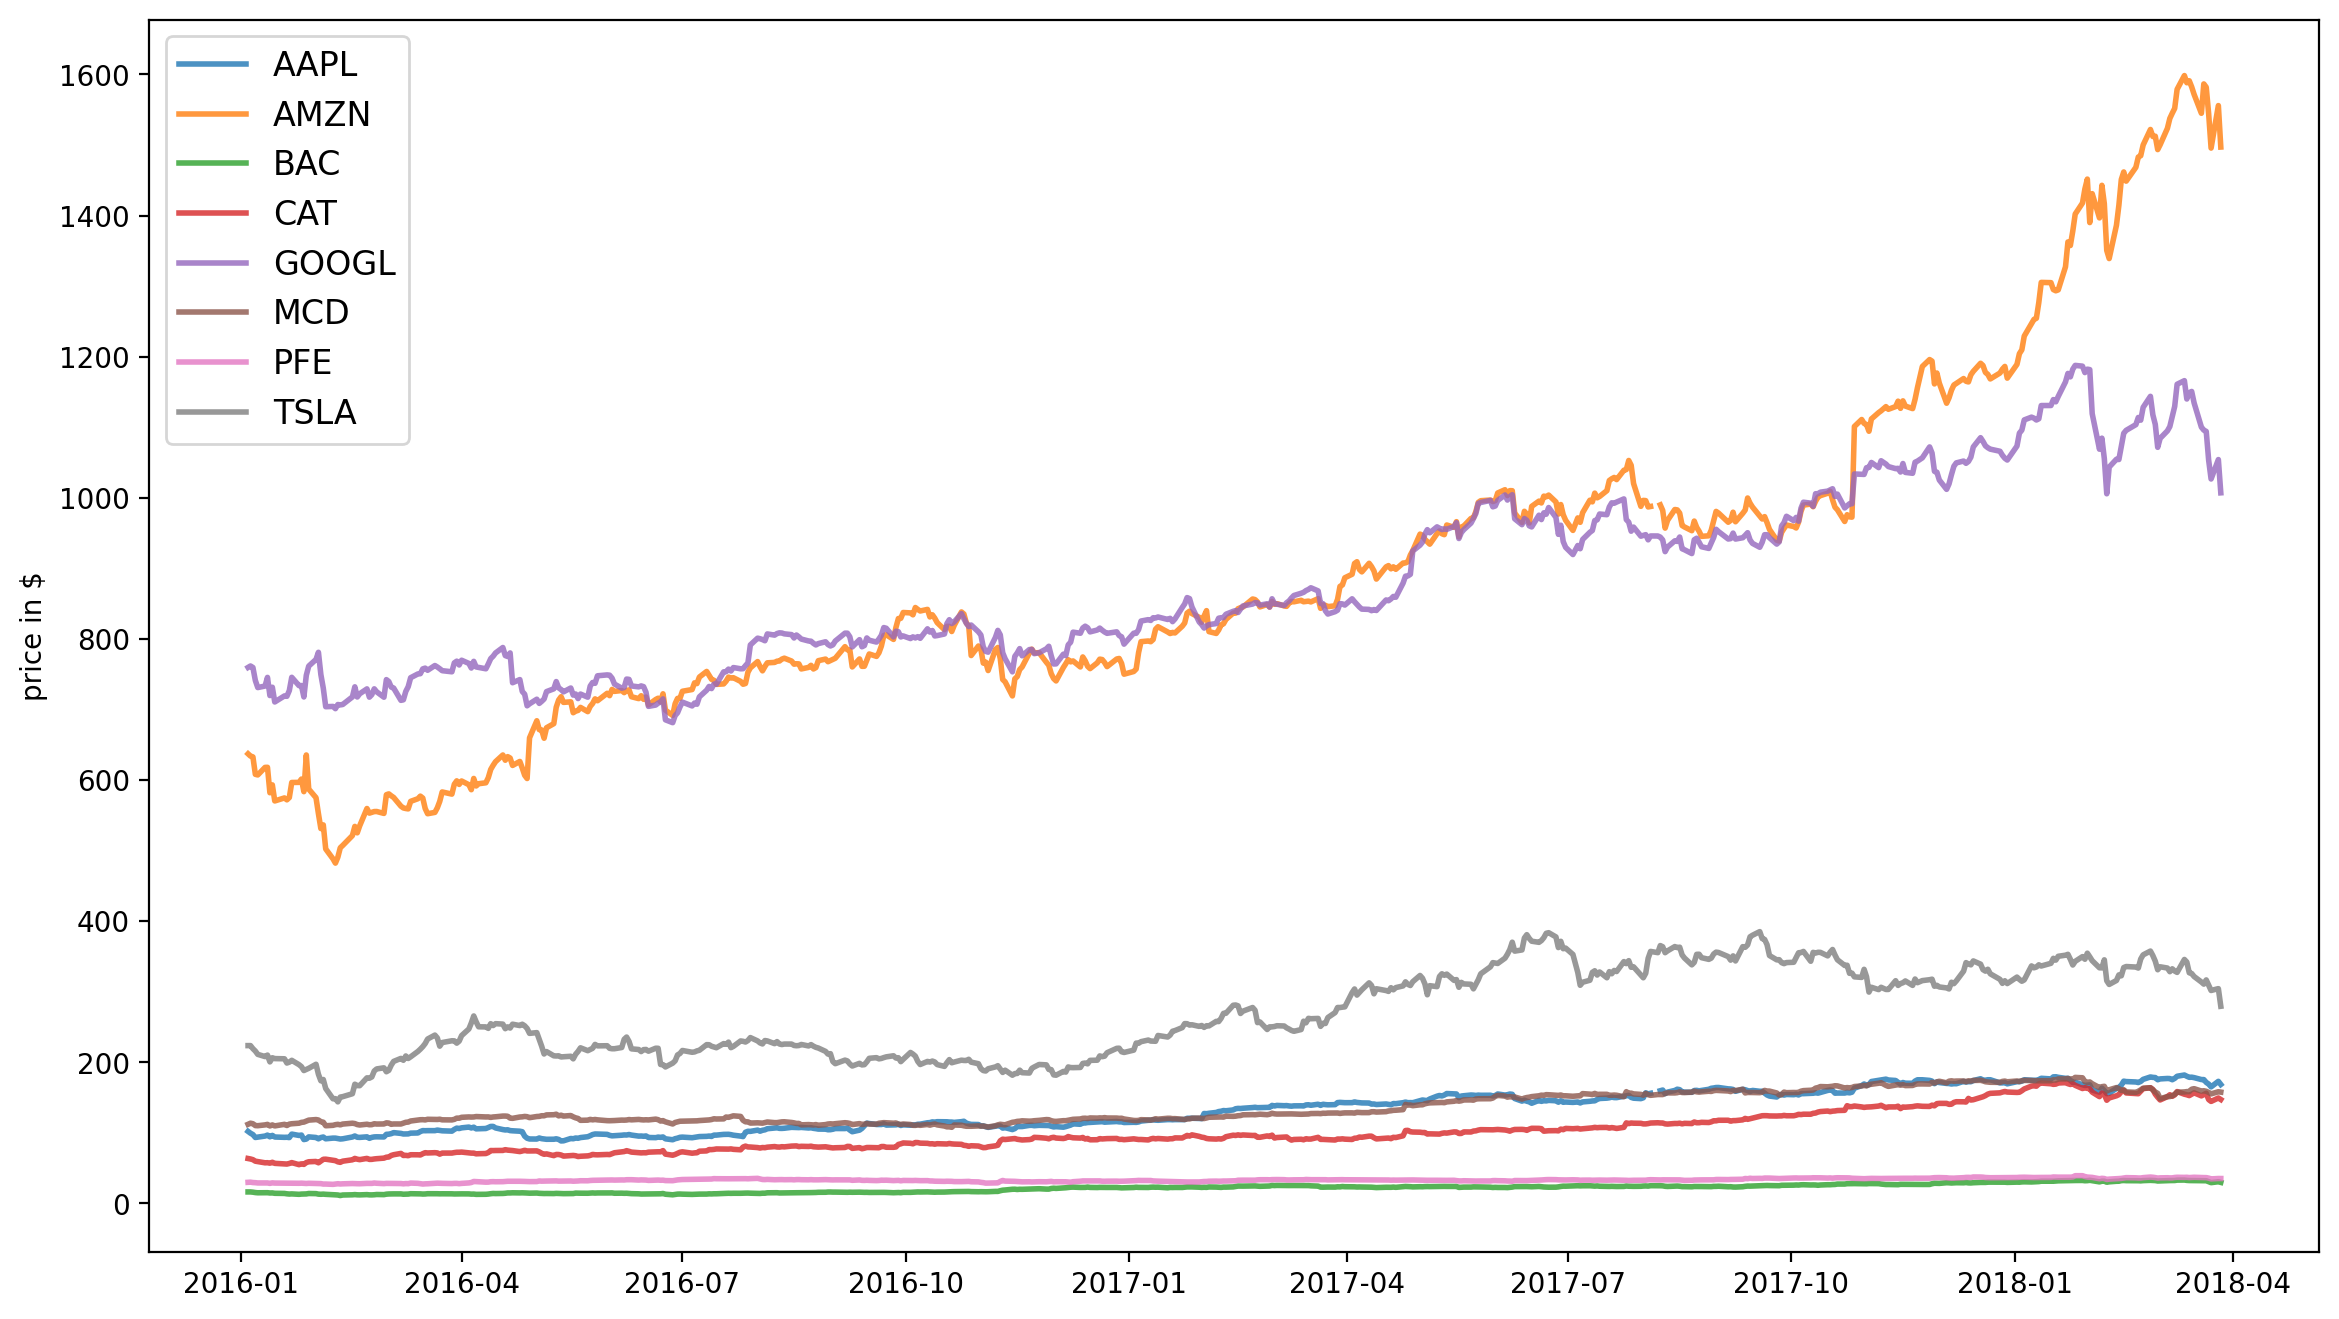

In [ ]:
plt.figure(figsize=(14, 8))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=2, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

There are some strong correlations among some of the stocks!

# Convert into returns
### In this case, one always use simple returns
We Always  use returns for correlation analysis

Text(0, 0.5, 'daily returns')

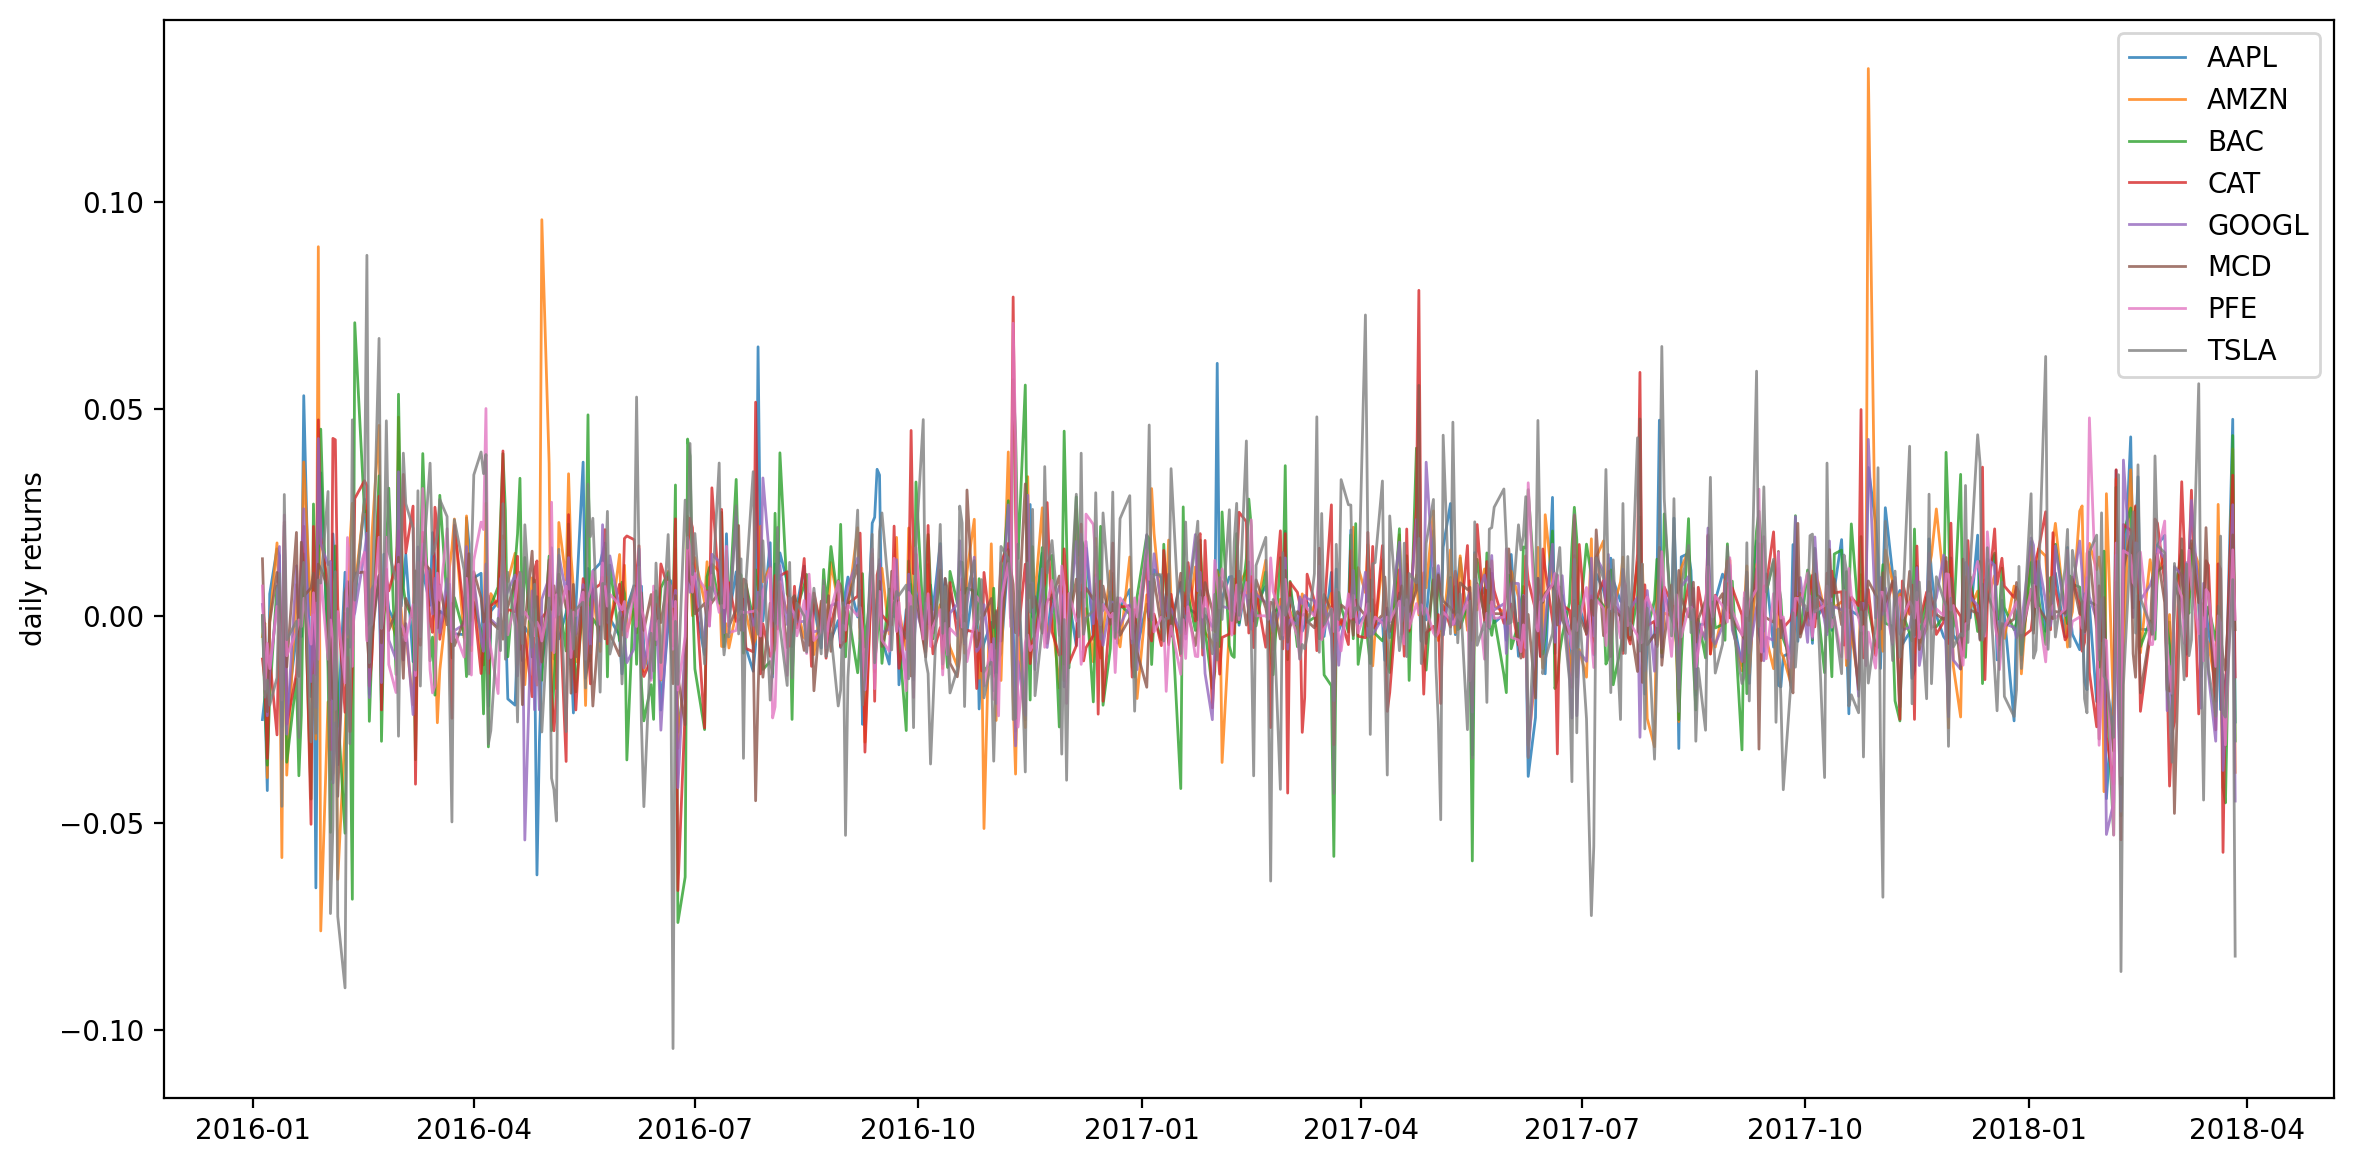

In [ ]:
returns = table.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=1, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=10)
plt.ylabel('daily returns')

# Random Portfolios Generation
Calculate the returns and std, and to make it as an annualized calculation we take into account 252 business days in one year

The convention for converting 1 day variance $\sigma^2_{day}$  to 1 year variance $\sigma^2_{year}$ is $$\sigma^2_{year}=\sigma^2_{day}\times 252$$
Equivalently,
$$\sigma_{year}=\sigma_{day}\times \sqrt{252}$$
Here
$$\sigma^2_P=\alpha^\top \times \Sigma\times\alpha $$
$$\sigma_P=\sqrt{\sigma^2_P}$$
$$r_P=\alpha^\top\times {\bf r}$$
$$SR_P=\frac{r_P-r_f}{\sigma_P}$$

In [ ]:

def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights )*252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))*np.sqrt(252)
    return std, returns

def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(stocks))
        weights /= np.sum(weights)  #make sure the sum is 1
        weights_record.append(weights)
        portfolio_std, portfolio_return = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std
    return results, weights_record

# From the historical data, we can estimate the imputs needed for the MV Analysis:
1. expected returns ${\bf r}$
2. variance-covariance matrix $\Sigma$
3. we also need risk free interest rate $r_f$

We are generating num_portfolios random portfolios


In [ ]:
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178



In [ ]:
mean_returns.round(4)

ticker
AAPL     0.0010
AMZN     0.0017
BAC      0.0012
CAT      0.0016
GOOGL    0.0006
MCD      0.0007
PFE      0.0004
TSLA     0.0007
dtype: float64

In [ ]:
cov_matrix.round(6)

ticker,AAPL,AMZN,BAC,CAT,GOOGL,MCD,PFE,TSLA
ticker,,,,,,,,
AAPL,0.000183,0.000094,0.000076,0.000073,0.000088,0.000032,0.000032,0.000092
AMZN,0.000094,0.000266,0.000066,0.000065,0.000121,0.000044,0.000027,0.000118
BAC,0.000076,0.000066,0.000298,0.000148,0.000070,0.000042,0.000067,0.000086
CAT,0.000073,0.000065,0.000148,0.000251,0.000060,0.000042,0.000047,0.000090
GOOGL,0.000088,0.000121,0.000070,0.000060,0.000152,0.000043,0.000040,0.000092
MCD,0.000032,0.000044,0.000042,0.000042,0.000043,0.000093,0.000024,0.000033
PFE,0.000032,0.000027,0.000067,0.000047,0.000040,0.000024,0.000109,0.000046
TSLA,0.000092,0.000118,0.000086,0.000090,0.000092,0.000033,0.000046,0.000554


In [ ]:
returns.corr().round(6)

ticker,AAPL,AMZN,BAC,CAT,GOOGL,MCD,PFE,TSLA
ticker,,,,,,,,
AAPL,1.000000,0.428348,0.327376,0.341375,0.530392,0.246603,0.226837,0.290030
AMZN,0.428348,1.000000,0.235822,0.252824,0.604476,0.279787,0.159865,0.307700
BAC,0.327376,0.235822,1.000000,0.542385,0.329278,0.248878,0.373186,0.211949
CAT,0.341375,0.252824,0.542385,1.000000,0.304802,0.277394,0.285641,0.240825
GOOGL,0.530392,0.604476,0.329278,0.304802,1.000000,0.358234,0.307390,0.315859
MCD,0.246603,0.279787,0.248878,0.277394,0.358234,1.000000,0.240445,0.147218
PFE,0.226837,0.159865,0.373186,0.285641,0.307390,0.240445,1.000000,0.186105
TSLA,0.290030,0.307700,0.211949,0.240825,0.315859,0.147218,0.186105,1.000000


<Axes: title={'center': 'Correlation Matrix'}, xlabel='ticker', ylabel='ticker'>

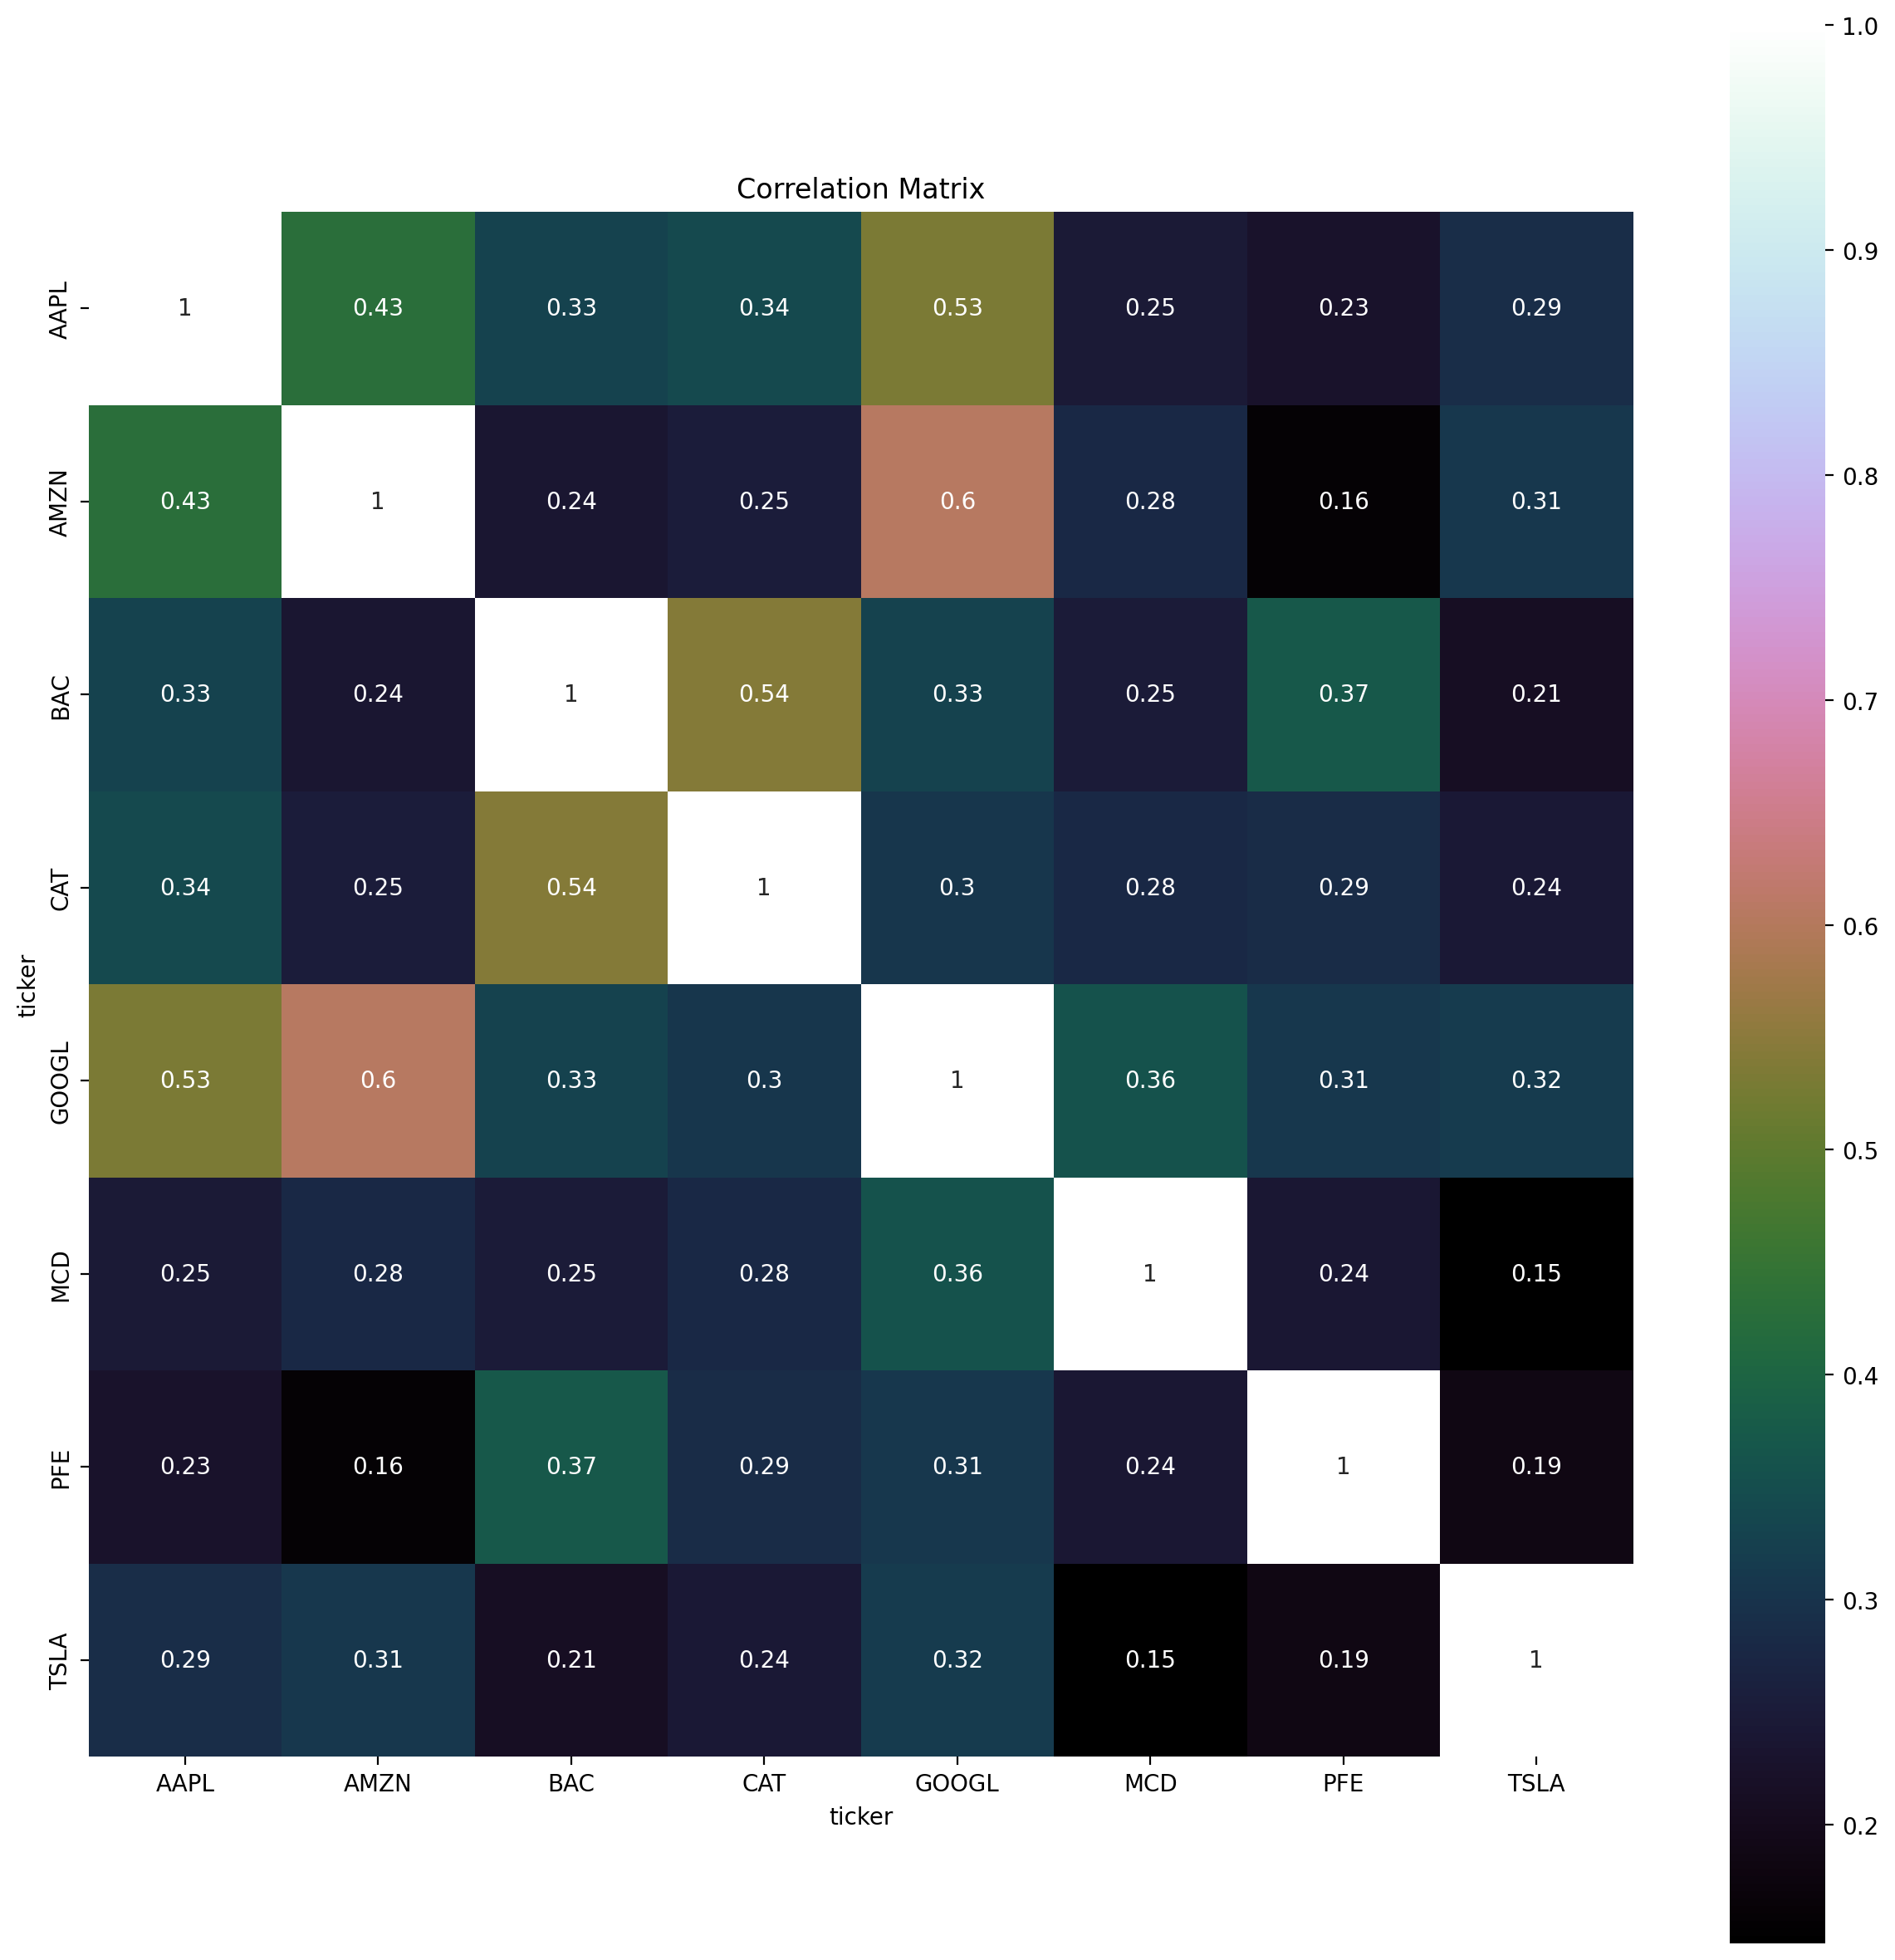

In [ ]:
correlation = returns.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

# Random Portfolios Generation
The value for weights will be the portion of budget we allocate to a specific stock.  

### Define a function to show how the results will be plotted
Let's define some functions to simulate random weights to each stock in the portfolio, then calculate the portfolio's overall annualized returns and annualized standard deviation.

"portfolio_annual_performance" function will calculate the returns and standard deviation. To make it as an annualized calculation we take into account 252 as the number of trading days in one year. "random_portfolios" function will generate portfolios with random weights assigned to each stock, and by passing num_portfolios argument, you can decide how many random portfolios you want to generate.

We also calculate the Sharpe Ratio for each portfolio and indicate the one with maximum value

In [ ]:
table.columns

Index(['AAPL', 'AMZN', 'BAC', 'CAT', 'GOOGL', 'MCD', 'PFE', 'TSLA'], dtype='object', name='ticker')

In [ ]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)

    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualized Return:", round(rp,2))
    print("Annualized STD:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum STD Portfolio Allocation\n")
    print("Annualized Return:", round(rp_min,2))
    print("Annualized STD:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)

    plt.figure(figsize=(12, 8))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='o',color='r',s=50, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='o',color='g',s=50, label='Minimum STD')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualized STD')
    plt.ylabel('annualized returns')
    plt.legend(labelspacing=0.8)


--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 0.34
Annualized STD: 0.17


ticker      AAPL   AMZN    BAC    CAT  GOOGL    MCD  PFE  TSLA
allocation  8.73  33.32  12.93  27.58   0.58  11.38  5.2  0.28
--------------------------------------------------------------------------------
Minimum STD Portfolio Allocation

Annualized Return: 0.2
Annualized STD: 0.12


ticker       AAPL   AMZN   BAC   CAT  GOOGL    MCD    PFE  TSLA
allocation  10.62  12.77  6.53  3.21   1.73  36.24  28.26  0.64


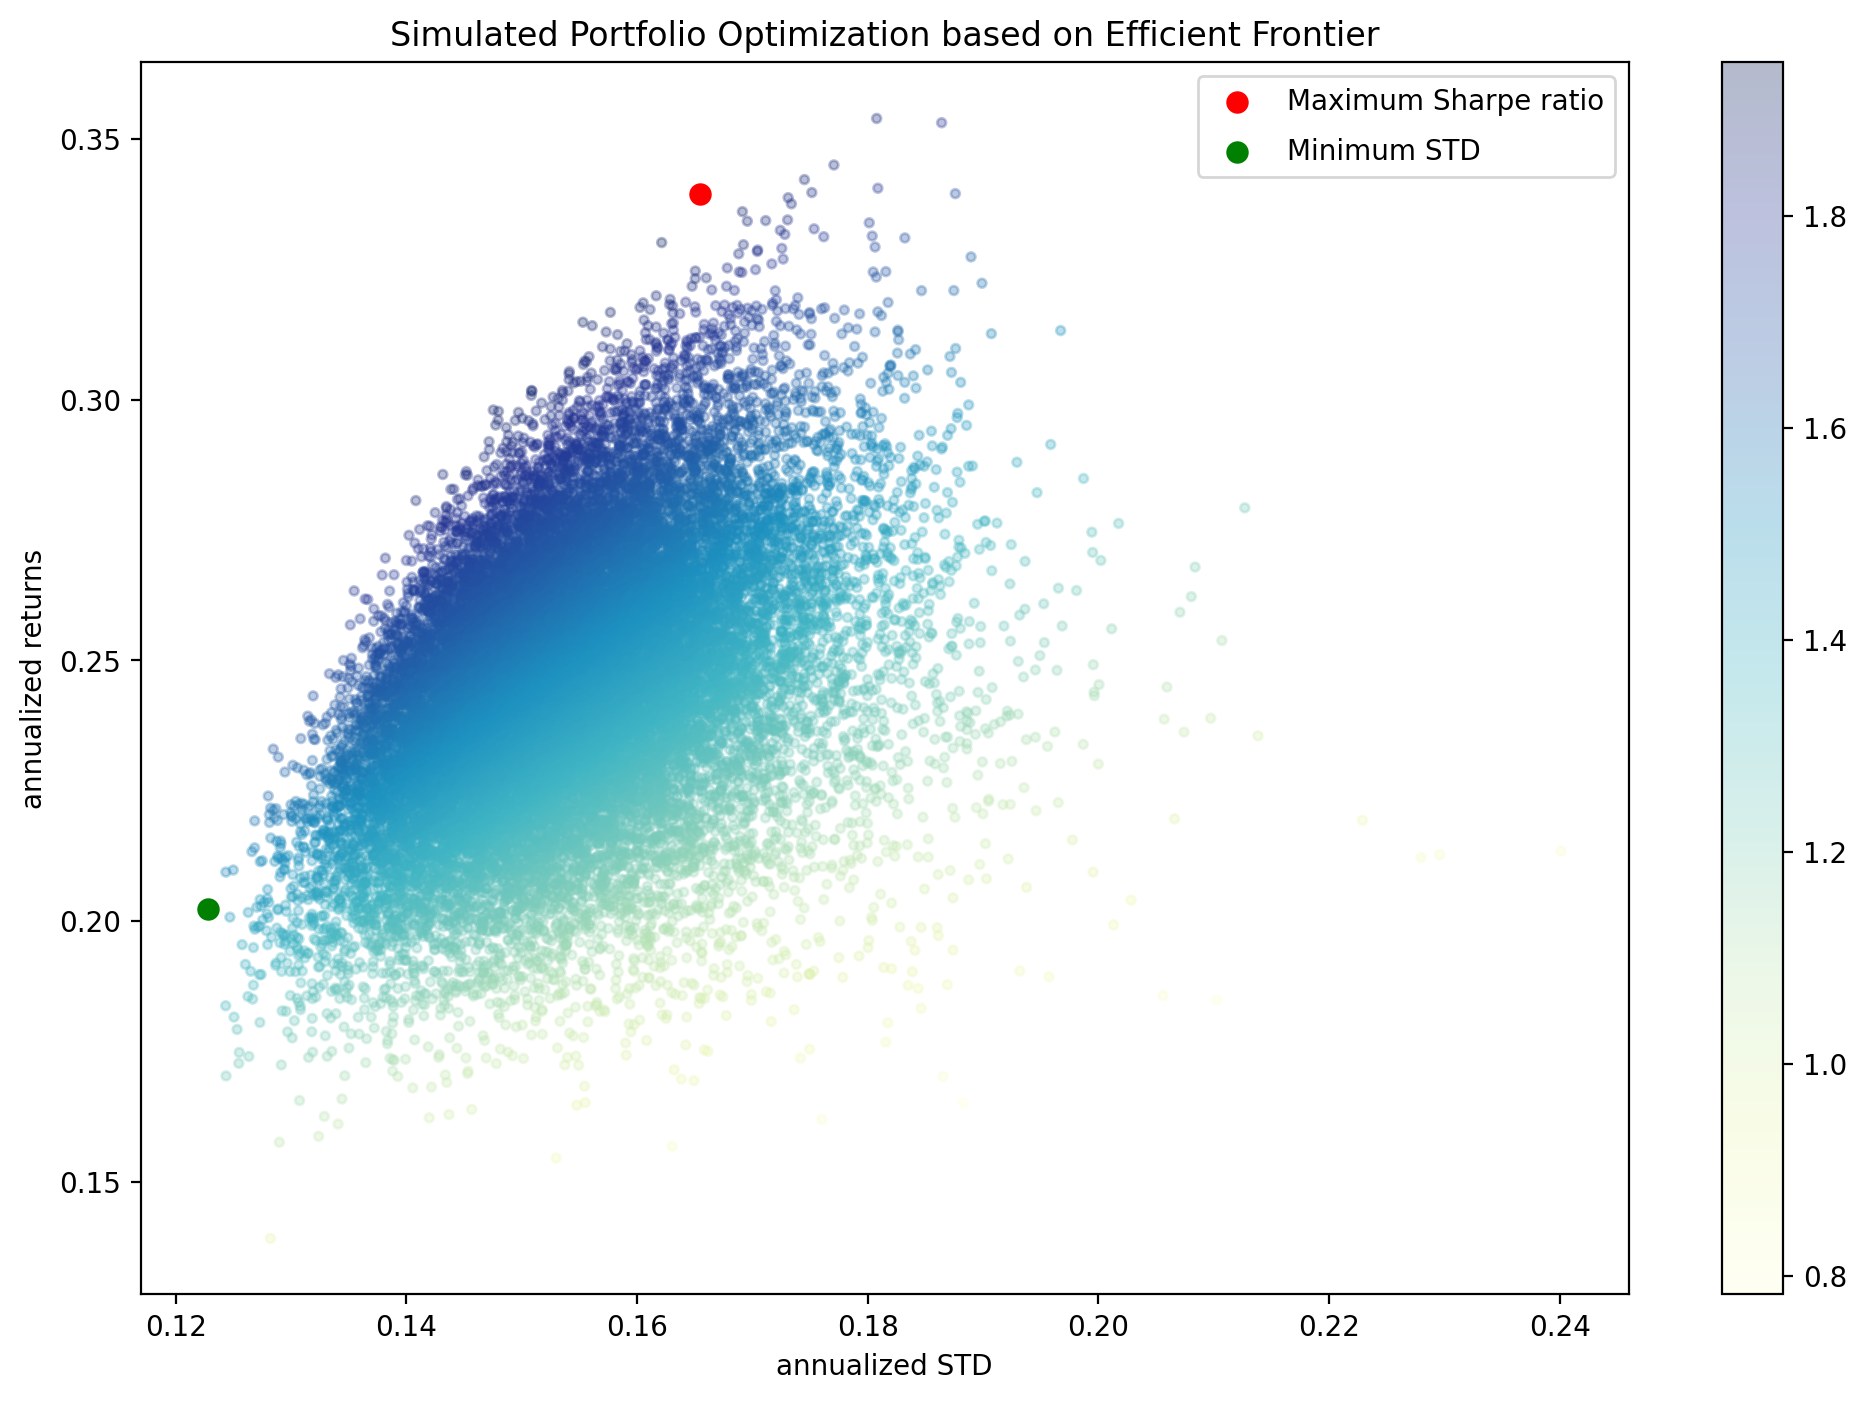

In [ ]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

# Efficient Frontier

The tangent portfolio is find by solving the following problem:
$$\max_{\bf x} \frac{\bar{r}_P-r_f}{\sigma_P} $$
where
$$\bar{r}_P={\bf x}^\top \mu$$
$$\sigma_P = \sqrt{{\bf x}^\top \Sigma {\bf x}} $$
$${\bf x}^\top {\bf 1}=1$$

For the efficient frontier, it can be  found in the following way:

For a given level of expected return $r_0$, we can find the portfolio with the minimal standard deviation ( or variance) that gives the expected return $r_0$:
$$ \min_{\bf x} {\bf x}^\top \Sigma {\bf x} $$
subject to
$${\bf x}^\top \mu=r_0$$
$${\bf x}^\top {\bf 1}=1$$

By varying the value of $r_0$, we can plot the efficient frontier

### Prepare the objective function ( - Sharpe Ratio, in this case)

In [ ]:
#Equality constraint: sum of weight =1, or np.sum(x)-1=0
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x)-1})

#we want to maximize the sharpe ratio, but the minimizing routine is foe min
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints) #sequential least squares programming algorithm
    return result

For a portfolio $\alpha$, its standard deviation is given by $\sigma_P=  \sqrt{\alpha^\top\Sigma\alpha}$, and expected return is $E(r_P)=\alpha^\top \mu $. This function was defined ealier

The 2nd function solves the minimization proble:
$$ \min_\alpha \sigma_P=\sqrt{\alpha^\top\Sigma\alpha}$$
This is the golbal minimum variance portfolio

**Note**: Assume there is no short sale allowed

In [ ]:
def portfolio_std(weights, mean_returns, cov_matrix):
    return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[0]

def min_std(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_std, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

###  First function:  For a givel of expected return ('target'), find the frontier portfloio that gives the same level of expected return

### Second function: record the frontier portfolios.

In [ ]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_std, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [ ]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)

    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualized_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_std(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualized_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualized Return:", round(rp,2))
    print("Annualized STD:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print( "Minimum STD Portfolio Allocation\n")
    print("Annualized Return:", round(rp_min,2))
    print("Annualized STD:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    plt.figure(figsize=(12, 8))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='o',color='r',s=50, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='o',color='g',s=50, label='Minimum STD')

    x0=[0,sdp]
    y0=[risk_free_rate, rp]
   # print("tp", sdp, rp)
    plt.plot(x0,y0)

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualized STD')
    plt.ylabel('annualized returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 0.36
Annualized STD: 0.17


ticker      AAPL   AMZN   BAC    CAT  GOOGL    MCD  PFE  TSLA
allocation  4.95  37.18  3.42  37.96    0.0  16.49  0.0   0.0
--------------------------------------------------------------------------------
Minimum STD Portfolio Allocation

Annualized Return: 0.16
Annualized STD: 0.12


ticker       AAPL  AMZN  BAC   CAT  GOOGL    MCD    PFE  TSLA
allocation  11.49  2.98  0.0  3.22   5.61  41.71  34.21  0.78


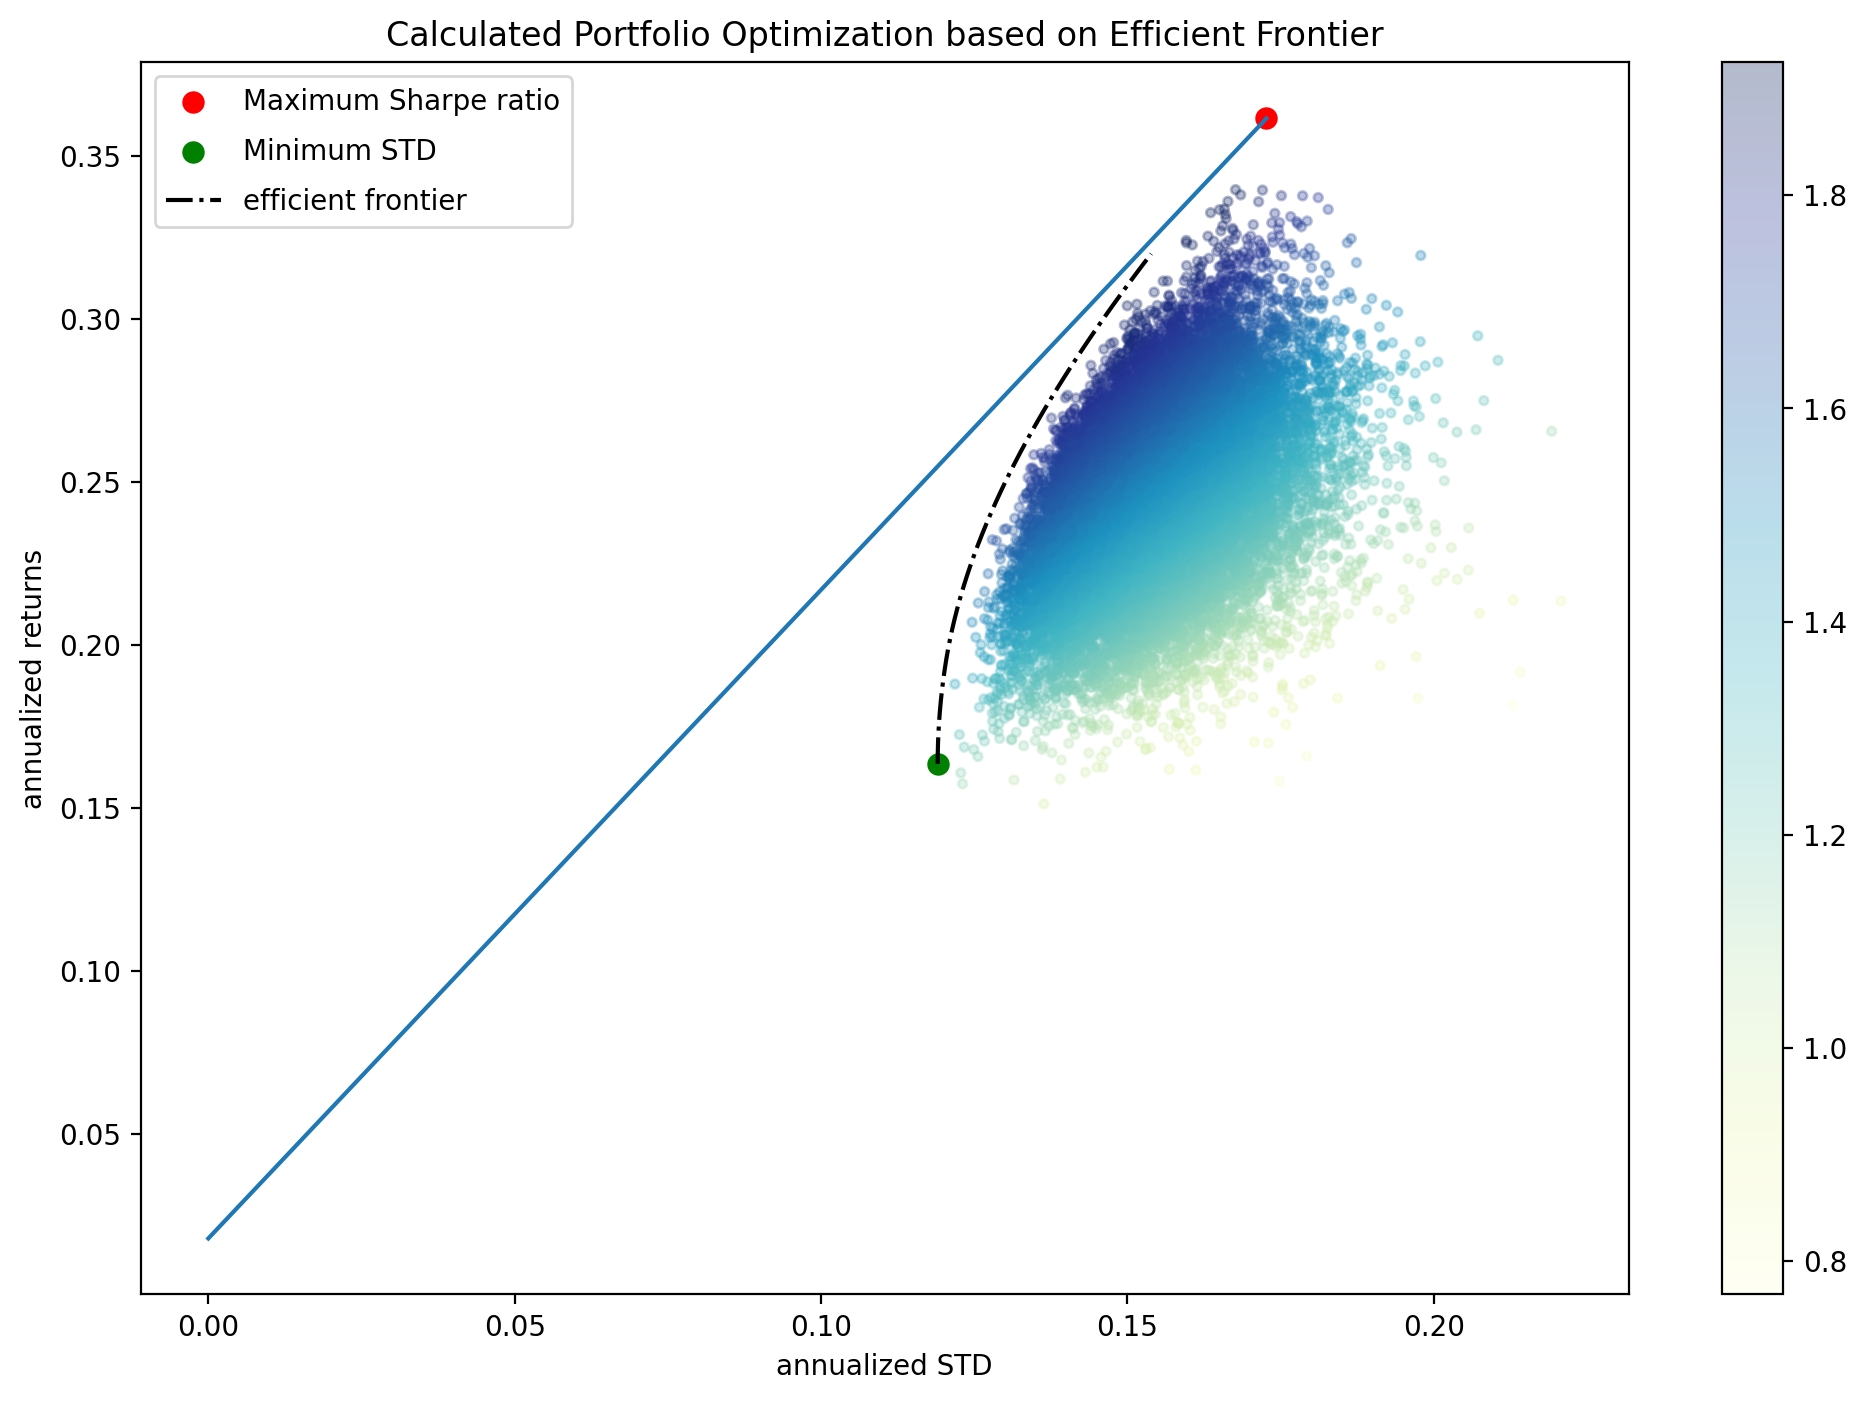

In [ ]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [ ]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualized_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_std(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualized_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T

    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252

    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualized Return:", round(rp,2))
    print("Annualized STD:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print( "Minimum STD Portfolio Allocation\n")
    print("Annualized Return:", round(rp_min,2))
    print("Annualized STD:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    print("-"*80)
    print("Individual Stock Returns and STD\n")
    for i, txt in enumerate(table.columns):
        print(txt,":","annuaized return",round(an_rt[i],2),", annualized STD:",round(an_vol[i],2))
    print("-"*80)

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='o',color='r',s=50, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='o',color='g',s=50, label='Minimum STD')

    x0=[0,sdp]
    y0=[risk_free_rate, rp]
   # print("tp", sdp, rp)
    plt.plot(x0,y0)

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualized STD')
    ax.set_ylabel('annualized returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualized Return: 0.36
Annualized STD: 0.17


ticker      AAPL   AMZN   BAC    CAT  GOOGL    MCD  PFE  TSLA
allocation  4.95  37.18  3.42  37.96    0.0  16.49  0.0   0.0
--------------------------------------------------------------------------------
Minimum STD Portfolio Allocation

Annualized Return: 0.16
Annualized STD: 0.12


ticker       AAPL  AMZN  BAC   CAT  GOOGL    MCD    PFE  TSLA
allocation  11.49  2.98  0.0  3.22   5.61  41.71  34.21  0.78
--------------------------------------------------------------------------------
Individual Stock Returns and STD

AAPL : annuaized return 0.25 , annualized STD: 0.21
AMZN : annuaized return 0.42 , annualized STD: 0.26
BAC : annuaized return 0.31 , annualized STD: 0.27
CAT : annuaized return 0.41 , annualized STD: 0.25
GOOGL : annuaized return 0.15 , annualized STD: 0.2
MCD : annuaized return 0.17 , annualized STD: 

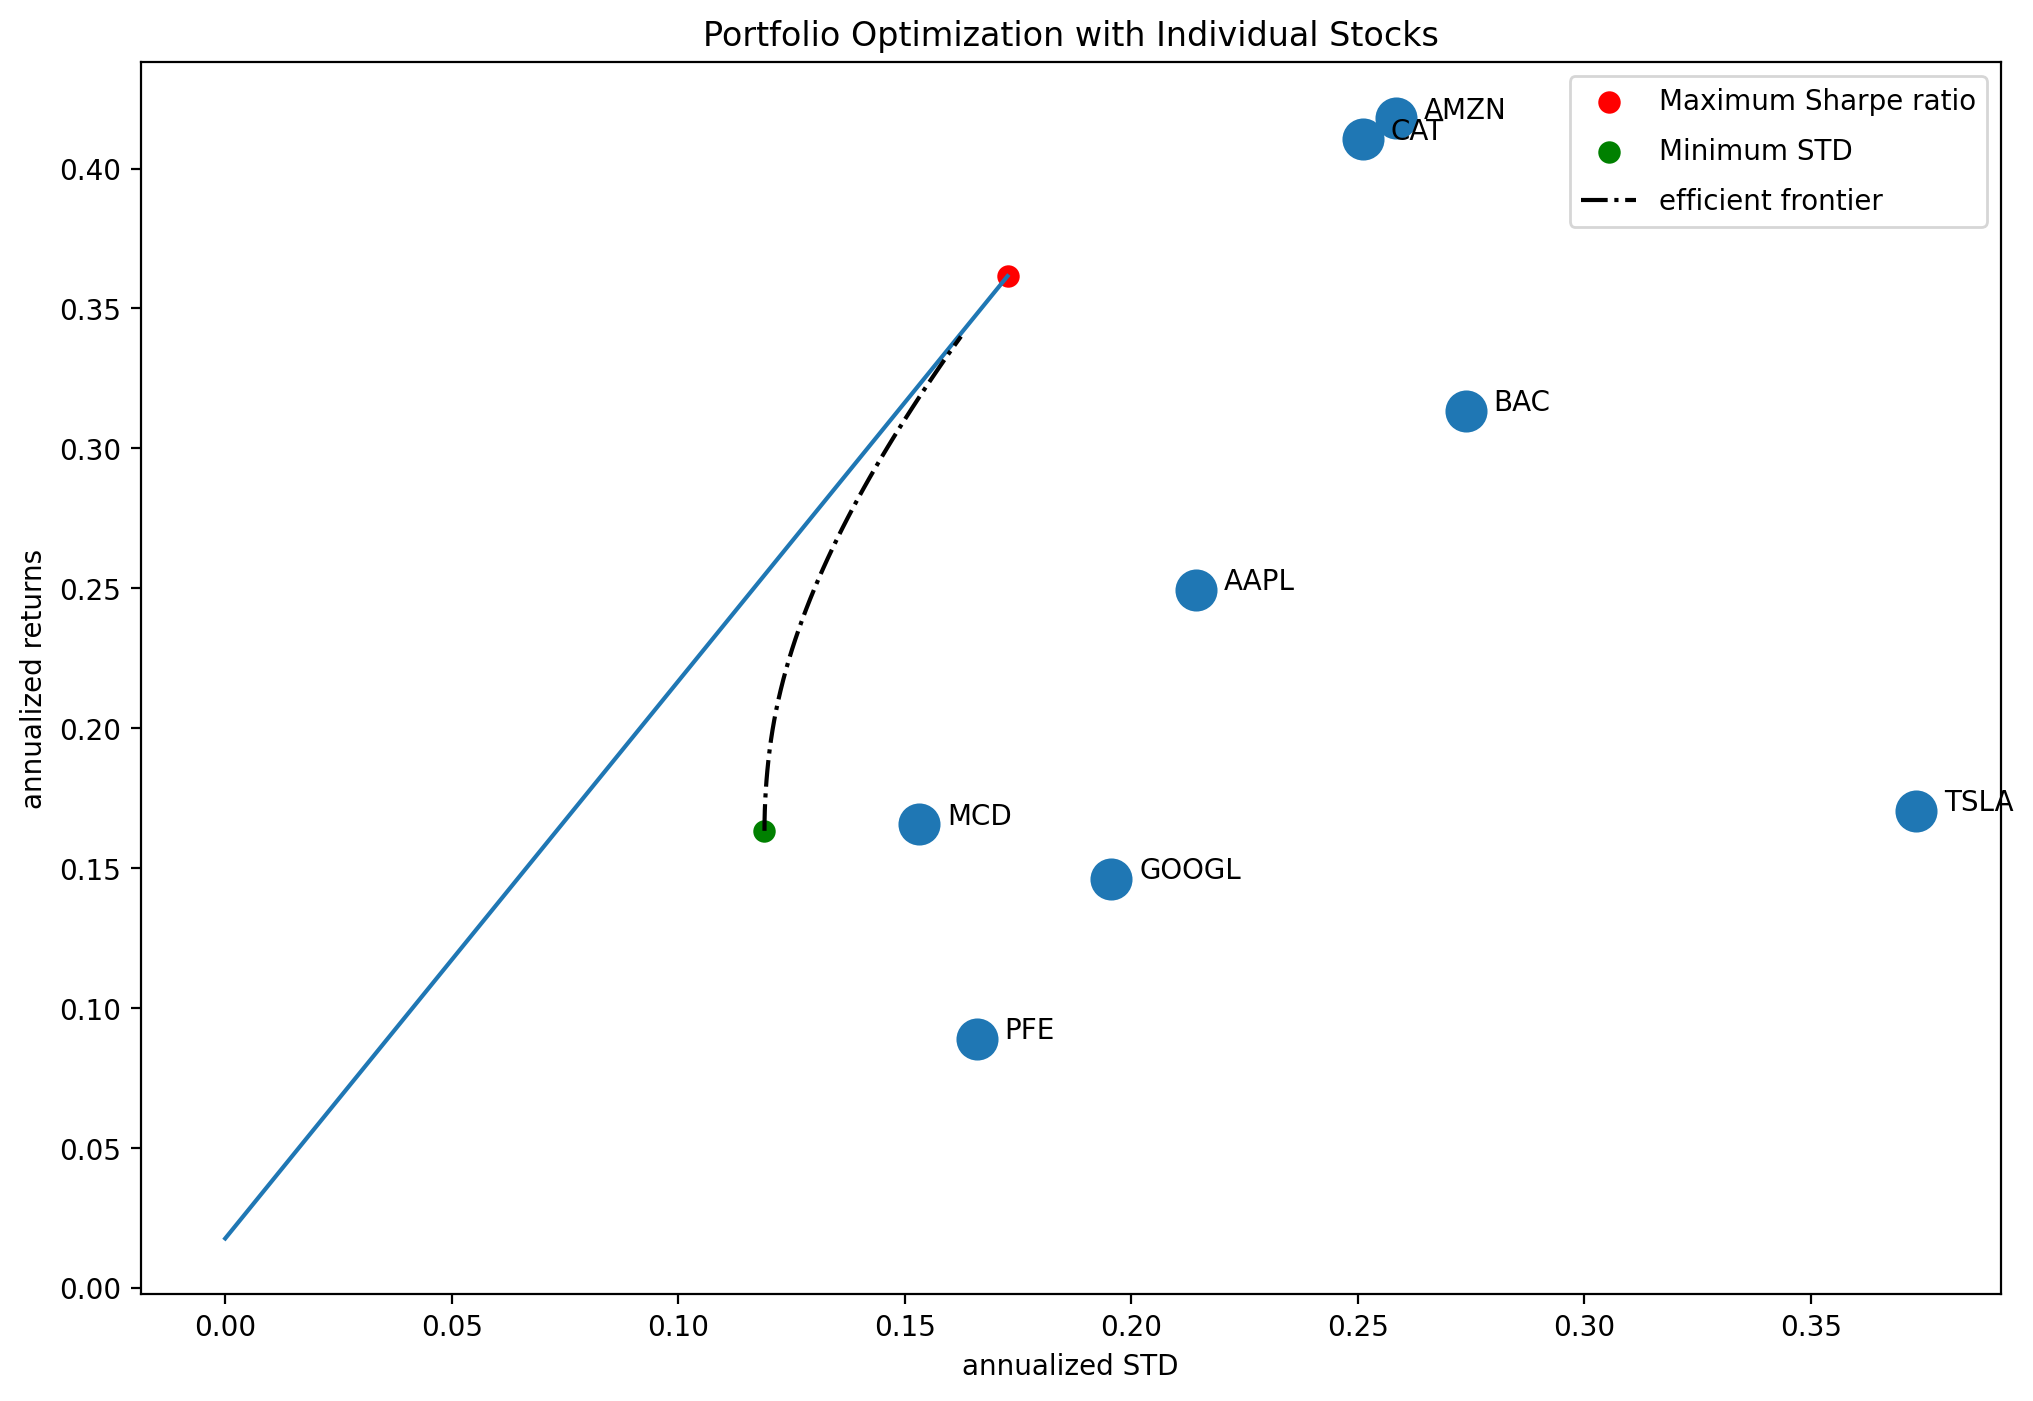

In [ ]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)